In [100]:
# Setup

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np

mouse_metadata = Path("data/Mouse_metadata.csv")
study_results = Path("data/Study_results.csv")

mouse_metadata_df = pd.read_csv(mouse_metadata)
study_results_df = pd.read_csv(study_results)

# display(mouse_metadata_df)
# display(study_results_df)

# Mouse_metadata contains identifying characteristics of each mouse as well as its assigned drug.
# Study_results is time-variant tumor data over 46 study days

study_complete_df = pd.merge(study_results_df, mouse_metadata_df, on="Mouse ID")
display(study_complete_df)

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [101]:
# Prepare the data: display then remove duplicate mice-timepoint data, establish de-duplicated DataFrame, display updated total mice

# Find the number of mice
print(f"Number of unique Mouse IDs: " + str(len(mouse_metadata_df["Mouse ID"].value_counts())))

# Locate mice with duplicate timepoint data
study_complete_df["Is Duplicated"] = study_complete_df.duplicated(subset=["Mouse ID", "Timepoint"], keep=False)
duplicates_df = study_complete_df.loc[study_complete_df["Is Duplicated"] == True, :]
print(f"Mice with duplicate timepoint data: " + str(duplicates_df["Mouse ID"].unique()))

# Display all data associated with above mice
duplicate_mouse_df = study_complete_df.loc[study_complete_df["Mouse ID"] == "g989", :]
display(duplicate_mouse_df)

# Remove above data to create a cleaned DataFrame
study_cleaned_df = study_complete_df.loc[study_complete_df["Mouse ID"] != "g989", :].drop("Is Duplicated", axis=1).reset_index(drop=True)
display(study_cleaned_df)

Number of unique Mouse IDs: 249
Mice with duplicate timepoint data: ['g989']


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g),Is Duplicated
107,g989,0,45.000000,0,Propriva,Female,21,26,True
137,g989,0,45.000000,0,Propriva,Female,21,26,True
329,g989,5,48.786801,0,Propriva,Female,21,26,True
360,g989,5,47.570392,0,Propriva,Female,21,26,True
620,g989,10,51.745156,0,Propriva,Female,21,26,True
681,g989,10,49.880528,0,Propriva,Female,21,26,True
815,g989,15,51.325852,1,Propriva,Female,21,26,True
869,g989,15,53.442020,0,Propriva,Female,21,26,True
950,g989,20,55.326122,1,Propriva,Female,21,26,True
1111,g989,20,54.657650,1,Propriva,Female,21,26,True


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1875,r944,45,41.581521,2,Capomulin,Male,12,25
1876,u364,45,31.023923,3,Capomulin,Male,18,17
1877,p438,45,61.433892,1,Ceftamin,Female,11,26
1878,x773,45,58.634971,4,Placebo,Female,21,30


In [102]:
# Generate summary statistics

# Filter for only data from 45 days
# study_cleaned_45_df = study_cleaned_df[study_cleaned_df["Timepoint"] == 45]

# Group the filtered data by drug
grouped_df = study_cleaned_df.groupby(["Drug Regimen"])
display(grouped_df.first())

# Record the summary statistics for each drug
mean = grouped_df["Tumor Volume (mm3)"].mean()
median = grouped_df["Tumor Volume (mm3)"].median()
variance = grouped_df["Tumor Volume (mm3)"].var()
std_dev = grouped_df["Tumor Volume (mm3)"].std()
sem = grouped_df["Tumor Volume (mm3)"].sem()

summary_statistics_df = pd.DataFrame({
    "Mean": mean,
    "Median": median,
    "Variance": variance,
    "Standard Deviation": std_dev,
    "Standard Error of the Mean": sem
})

summary_statistics_df


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Sex,Age_months,Weight (g)
Drug Regimen,,,,,,,
Capomulin,b128,0,45.0,0,Female,9,22
Ceftamin,x822,0,45.0,0,Male,3,29
Infubinol,c326,0,45.0,0,Female,18,25
Ketapril,f932,0,45.0,0,Male,15,29
Naftisol,f993,0,45.0,0,Male,21,28
Placebo,a897,0,45.0,0,Male,7,28
Propriva,n630,0,45.0,0,Female,15,29
Ramicane,c458,0,45.0,0,Female,23,20
Stelasyn,f234,0,45.0,0,Male,14,28


,Mean,Median,Variance,Standard Deviation,Standard Error of the Mean
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


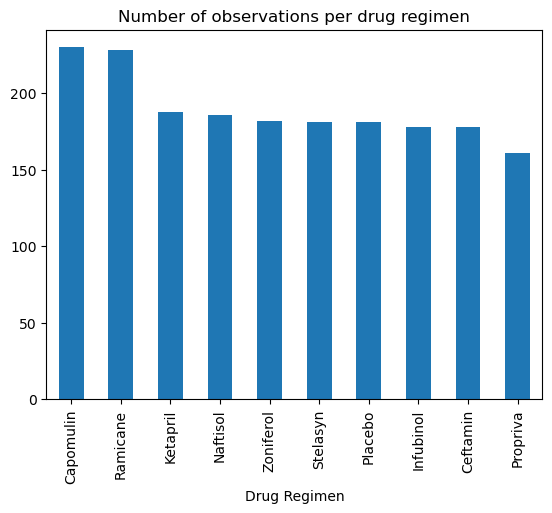

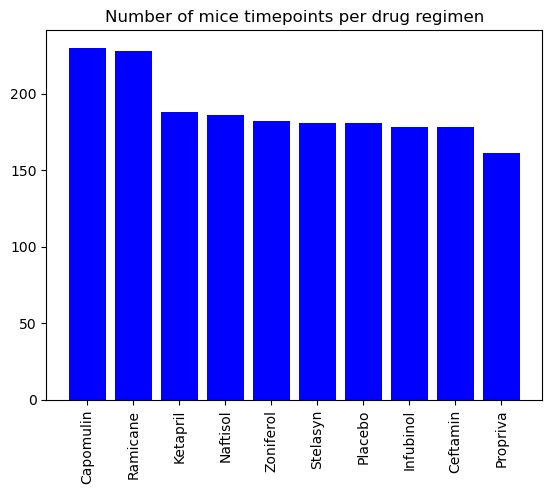

In [103]:
# Create bar charts

total_rows_df = study_complete_df["Drug Regimen"].value_counts()

# Create bar chart using DataFrame.plot() method
total_rows_df.plot(kind="bar")
plt.title("Number of observations per drug regimen")
plt.show()

# Create bar chart using matplotlib plt.plot() method
x_axis = np.arange(0,10)
plt.bar(x_axis, total_rows_df, color="b")
plt.title("Number of mice timepoints per drug regimen")

drug_regimens = pd.Series(total_rows_df.index)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, drug_regimens, rotation="vertical")
plt.show();

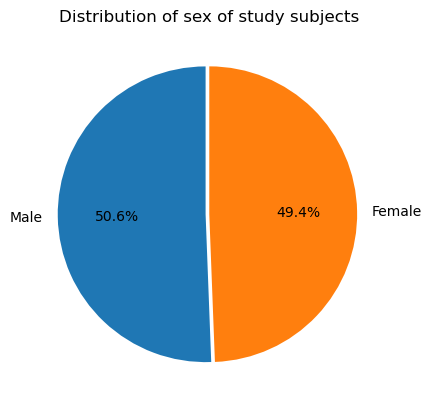

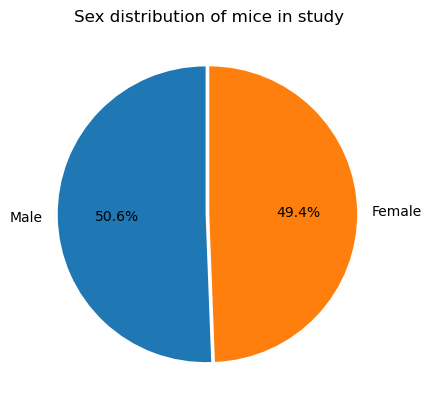

In [104]:
# Create pie charts

sex_df = study_complete_df["Sex"].value_counts()

explode = (0.025, 0)

sex_df.plot(kind="pie", startangle=90, autopct="%1.1f%%",explode=explode, title="Distribution of sex of study subjects", ylabel='')
plt.show()

plt.pie(sex_df, labels=sex_df.index, startangle=90, autopct="%1.1f%%", explode=explode)
plt.title("Sex distribution of mice in study")
plt.show()


In [105]:
# Calculate quartiles, find outliers, and create a box plot

# Group by mouse and display the last timepoint for each mouse
grouped_df = study_cleaned_df.groupby(["Mouse ID"])
timepoint_45_df = grouped_df.last()
display(timepoint_45_df)
# study_cleaned_df.loc[study_cleaned_df["Mouse ID"] == "z435", :] Just checking if groupby Mouse ID is working correctly

# Create new DataFrame that adds final timepoint's tumor volume to each row
timepoint_45_mergeprep_df = timepoint_45_df[["Tumor Volume (mm3)"]].rename(columns={"Tumor Volume (mm3)": "Final Tumor Volume"})
study_final_df = pd.merge(study_cleaned_df, timepoint_45_mergeprep_df, on="Mouse ID")
display(study_final_df)

# Create list to hold final tumor volume data to prepare for plotting
drugs_of_interest = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]
display(drugs_of_interest)
final_tumor_volume_ =[]

#
for drug in drugs_of_interest:
    print(drug)

,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
Mouse ID,,,,,,,
a203,45,67.973419,2,Infubinol,Female,20,23
a251,45,65.525743,1,Infubinol,Female,21,25
a262,45,70.717621,4,Placebo,Female,17,29
a275,45,62.999356,3,Ceftamin,Female,20,28
a366,30,63.440686,1,Stelasyn,Female,16,29
...,...,...,...,...,...,...,...
z435,10,48.710661,0,Propriva,Female,12,26
z578,45,30.638696,0,Ramicane,Male,11,16
z581,45,62.754451,3,Infubinol,Female,24,25


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g),Final Tumor Volume
0,b128,0,45.000000,0,Capomulin,Female,9,22,38.982878
1,f932,0,45.000000,0,Ketapril,Male,15,29,45.000000
2,g107,0,45.000000,0,Ketapril,Female,2,29,71.905117
3,a457,0,45.000000,0,Ketapril,Female,11,30,49.783419
4,c819,0,45.000000,0,Ketapril,Male,21,25,62.175705
...,...,...,...,...,...,...,...,...,...
1875,r944,45,41.581521,2,Capomulin,Male,12,25,41.581521
1876,u364,45,31.023923,3,Capomulin,Male,18,17,31.023923
1877,p438,45,61.433892,1,Ceftamin,Female,11,26,61.433892
1878,x773,45,58.634971,4,Placebo,Female,21,30,58.634971


['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

Capomulin
Ramicane
Infubinol
Ceftamin


Mouse l509 was treated with Capomulin. Below is displayed its tumor volume over time.


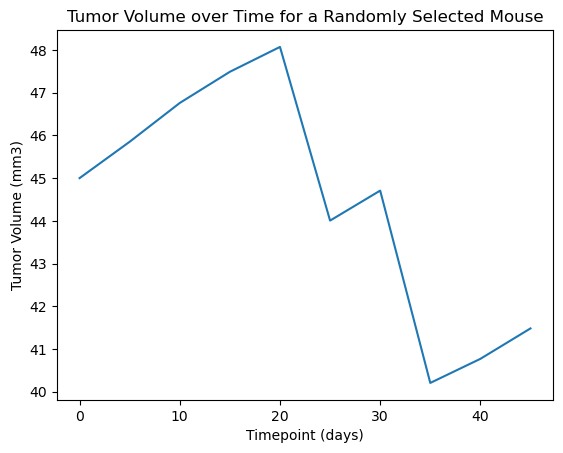

In [131]:
# Create a line plot and a scatter 

# Select a single mouse that was treated with a selected drug
drug = "Capomulin" # Define the selected drug
mice = study_cleaned_df.loc[study_cleaned_df["Drug Regimen"] == drug, "Mouse ID"].unique() # Get all mice treated by the selected drug
mouse = np.random.choice(mice) # Choose a mouse randomly
print(f"Mouse " + str(mouse) + " was treated with " + str(drug) + ". Below is displayed its tumor volume over time.")

# Create a line plot of tumor volume versus timepoint
mouse_data_df = study_cleaned_df.loc[study_cleaned_df["Mouse ID"] == mouse, ["Timepoint", "Tumor Volume (mm3)"]] # Select data for the plot's x and y
# print(mouse_data_df)

plt.plot(mouse_data_df["Timepoint"], mouse_data_df["Tumor Volume (mm3)"])
plt.title("Tumor Volume over Time for a Randomly Selected Mouse")
plt.xlabel("Timepoint (days)")
plt.ylabel("Tumor Volume (mm3)")
plt.show()

,Timepoint,Weight (g),Tumor Volume (mm3)
0,0,15,45.000000
1,0,17,45.000000
2,0,19,45.000000
3,0,20,45.000000
4,0,21,45.000000
...,...,...,...
85,45,21,39.280453
86,45,22,39.571049
87,45,23,39.426871
88,45,24,47.685963


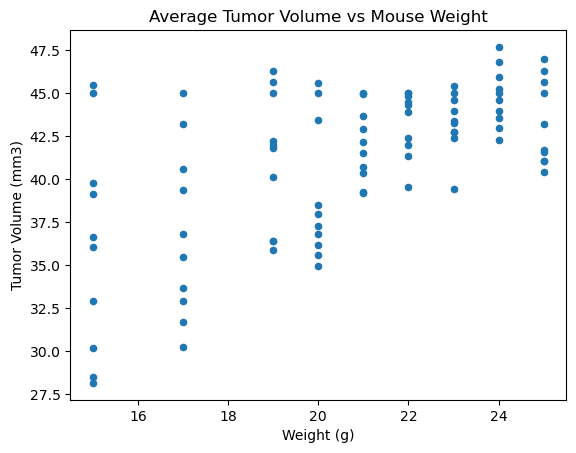

,Timepoint,Weight (g),Tumor Volume (mm3)
0,0,15,45.000000
9,5,15,45.473753
18,10,15,39.113891
27,15,15,39.776250
36,20,15,36.065835
45,25,15,36.617120
54,30,15,32.915292
63,35,15,30.206825
72,40,15,28.167397
81,45,15,28.484033


In [161]:
# Create a scattor plot of mouse weight vs. average tumor volume for the selected drug
mouse_data_df = study_cleaned_df.loc[study_cleaned_df["Drug Regimen"] == drug, ["Timepoint", "Weight (g)", "Tumor Volume (mm3)"]] # Select data
average_tumor_volume_df = mouse_data_df.groupby(["Timepoint", "Weight (g)"])["Tumor Volume (mm3)"].mean().reset_index()
display(average_tumor_volume_df)
average_tumor_volume_df.plot(kind="scatter", x="Weight (g)", y="Tumor Volume (mm3)", grid=False, title="Average Tumor Volume vs Mouse Weight")
plt.show()
display(average_tumor_volume_df.loc[average_tumor_volume_df["Weight (g)"] == 15, :])
# display(mouse_data_df)
# display(mouse_data_df["Mouse ID"].unique())


In [13]:
# Calculate correlation and regression